In [2]:
import csv
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [15, 15]
from tqdm import tqdm_notebook
import random
import numpy as np

In [3]:
def read_points(dataset_name, label_col_number):
    points = []
    labels = []
    with open (dataset_name, 'r') as fin:
        csvReader = csv.reader(fin, delimiter=',')
        for row in csvReader:
            if csvReader.line_num != 1:
                float_row = []
                for i in range(0, len(row)):
                    if i != label_col_number:
                        float_row.append(float(row[i]))
                points.append(float_row)
                labels.append(row[label_col_number])
    return points, labels

In [4]:
def split(points, labels):
    test_indexes = random.sample(range(len(points)), len(points) // 5)
    train_indexes = set([i for i in range(len(points))]) - set(test_indexes)
    return [points[i] for i in train_indexes], [labels[i] for i in train_indexes], [points[i] for i in test_indexes], [labels[i] for i in test_indexes]

In [5]:
def bayesian_classifier(train_points, train_labels, unique_labels):
    label_mu = []
    label_sigma = []
    label_prob = []
    for i in range(len(unique_labels)):
        label = unique_labels[i]
        label_points = []
        for j in range(len(train_points)):
            if train_labels[j] == label:
                label_points.append(train_points[j])
        label_prob.append(len(label_points) * 1.0 / len(train_points))
        label_mu.append([])
        label_sigma.append([])
        label_points = np.array(label_points)
        for j in range(len(train_points[0])):
            label_mu[i].append(np.average(label_points[:,j]))
            label_sigma[i].append(np.var(label_points[:,j]))
    return label_prob, label_mu, label_sigma
    

In [6]:
def roc(points, labels, true_label, scores, true_label_scores):
    x = [0]
    y = [0]
    for j in range(len(true_label_scores)):
        true_score = true_label_scores[j]
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(len(scores)):
            if scores[i] >= true_score:
                if labels[i] == true_label:
                    tp += 1
                else:
                    fp += 1
            else:
                if labels[i] == true_label:
                    fn += 1
                else:
                    tn += 1
        if tp + fn != 0:
            y.append(tp * 1.0 / (tp + fn))
        else:
            y.append(0)
        if fp + tn != 0:
            x.append(fp * 1.0 / (fp + tn))
        else:
            x.append(0)
    return x, y

In [7]:
import math
def bayess_predict(label_prob, label_mu, label_sigma, point, unique_labels):
    max_score = None
    max_label = None
    scores = []
    for i in range(len(unique_labels)):
        score = np.log(label_prob[i])
        for j in range(len(point)):
            mu = label_mu[i][j]
            sigma = label_sigma[i][j]
            score += -1.0 / 2 * np.log(2 * np.pi * sigma) - (point[j] - mu) ** 2 / (2 * sigma)
        scores.append(score)
        if not max_score or score > max_score:
            max_score = score
            max_label = unique_labels[i]
    other_score = 0
    if max_score == scores[0]:
        other_score = scores[1]
    else:
        other_score = scores[0]
    result = 1.0 / (np.exp(other_score - max_score))
    if not math.isnan(result):
        return result, max_label
    return 0.5, max_label    
    

In [8]:
def test_bayesian_classifier(dataset_name, label_col_number, true_label):
    points, labels = read_points(dataset_name, label_col_number)
    unique_labels = np.unique(np.array(labels)).tolist()
    train_points, train_labels, test_points, test_labels = [], [], [], []
    while(True):
        train_points, train_labels, test_points, test_labels = split(points, labels)
        label_prob, label_mu, label_sigma = bayesian_classifier(train_points, train_labels, unique_labels)
        scores = []
        is_true = []
        accuracy = 0
        for i in range(len(test_points)):
            point = test_points[i]
            score, label = bayess_predict(label_prob, label_mu, label_sigma, point, unique_labels)
            is_true.append(label == true_label)
            scores.append(score)
            if (test_labels[i] == label):
                accuracy += 1
        for i in range(len(test_points)):
            if not is_true[i]:
                scores[i] = 1 - scores[i]
        true_label_scores = list(scores)
        true_label_scores = sorted(set(true_label_scores), reverse=True)
        if (len(true_label_scores) > 2):
            #Too small scores
            break
    print("Accuracy = " + str(accuracy * 1.0 / len(test_points)))
    x, y = roc(test_points, test_labels, true_label, scores, true_label_scores)
    plt.plot(x, y)
    plt.show()

/Users/mari/Documents/ML/hw3/venv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars


Accuracy = 0.938053097345


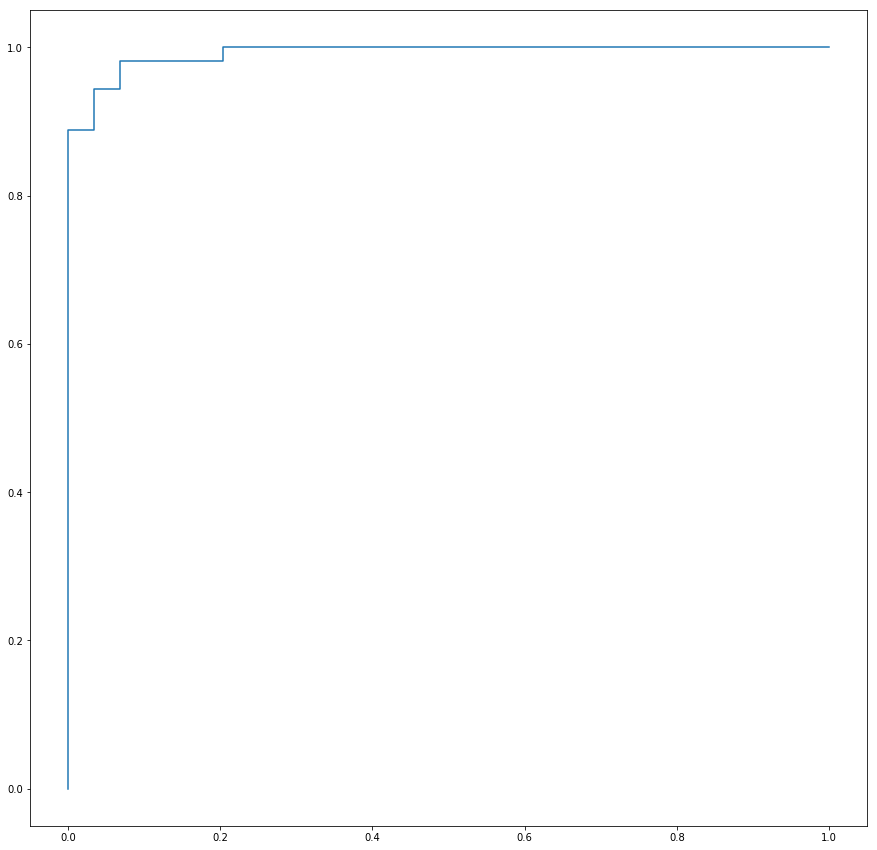

In [9]:
test_bayesian_classifier('../Datasets/cancer.csv', 0, 'M')

/Users/mari/Documents/ML/hw3/venv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
/Users/mari/Documents/ML/hw3/venv/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars


Accuracy = 0.826086956522


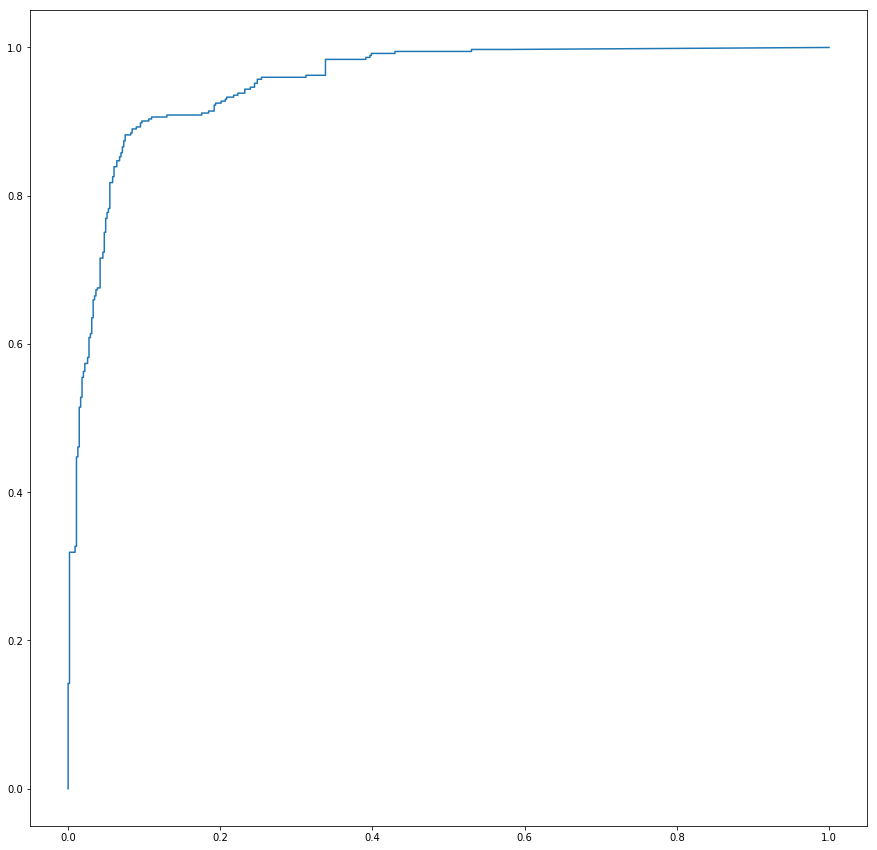

In [10]:
test_bayesian_classifier('../Datasets/spam.csv', 57, '1')